In [208]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import pandas as pd
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor

#### Data Visualizations

I will first need to plot features against my target variable to understanding the nature of the distributions. 

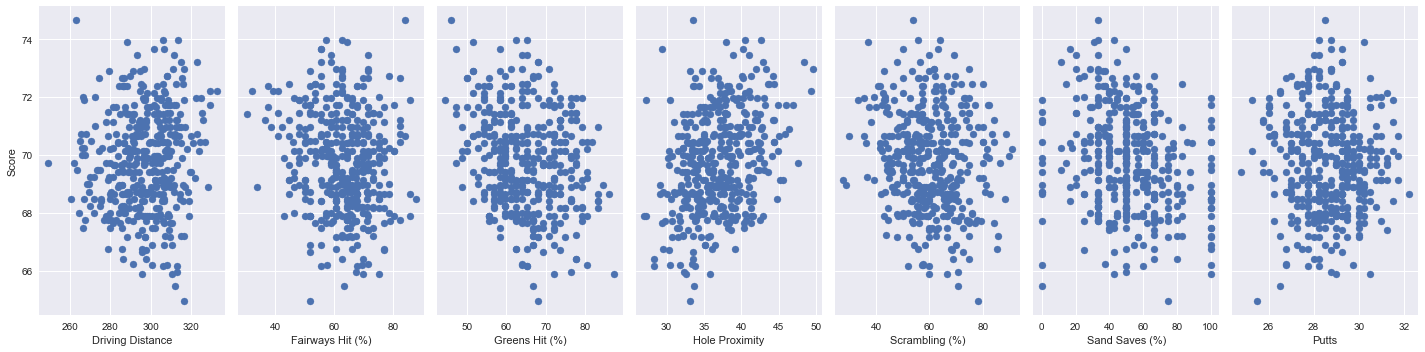

In [101]:
cleanedData = pd.read_csv('../data/cleaned_data/cleaned_subset')

# understanding each feature's relationship with the dependent variable (score)
yAxis = cleanedData['Score']
features = ['Driving Distance', 'Fairways Hit (%)', 'Greens Hit (%)', 'Hole Proximity', 'Scrambling (%)','Sand Saves (%)', 'Putts']

fig, ax = plt.subplots(1, 7, figsize=(20, 5), sharey=True)

for i in range(len(ax)):
    ax[i].scatter(cleanedData[features[i]], yAxis)
    ax[i].set_xlabel(features[i])
        
ax[0].set_ylabel('Score')
fig.tight_layout()
plt.show()  

The data seems slightly linear (hole proximity and greens hit) and as such a linear regression should suit the data. Next I will need to understand the correlations of the features to avoid using features that too closely correlated.

                  Driving Distance  Fairways Hit (%)  Greens Hit (%)  \
Driving Distance          1.000000         -0.409994        0.256419   
Fairways Hit (%)         -0.409994          1.000000        0.215172   
Greens Hit (%)            0.256419          0.215172        1.000000   
Hole Proximity            0.179888         -0.299236       -0.194712   
Scrambling (%)            0.129106          0.097118        0.272301   
Sand Saves (%)           -0.074188          0.070242        0.086136   
Putts                    -0.016764          0.039094        0.323487   

                  Hole Proximity  Scrambling (%)  Sand Saves (%)     Putts  
Driving Distance        0.179888        0.129106       -0.074188 -0.016764  
Fairways Hit (%)       -0.299236        0.097118        0.070242  0.039094  
Greens Hit (%)         -0.194712        0.272301        0.086136  0.323487  
Hole Proximity          1.000000        0.082019       -0.028867 -0.137527  
Scrambling (%)          0.082019      

<AxesSubplot:>

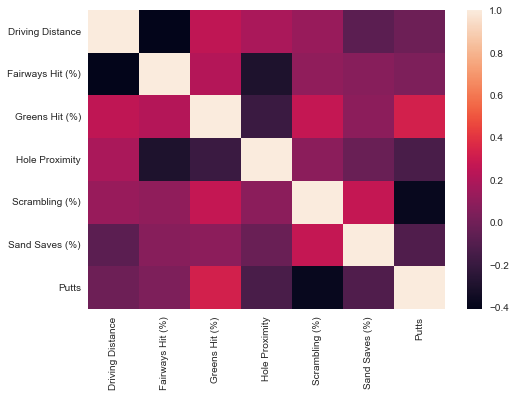

In [102]:
#correlation for independant variables, we want correleations to be -0.5 > x > 0.5 
featureSubset = cleanedData.loc[:, cleanedData.columns != 'Score']

print(featureSubset.corr())
sns.heatmap(featureSubset.corr())

#### Define Linear Function and Cost Function

The weights and features will be modeled as vectors and defined as:

$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$

$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$

 

Now the linear function is defined as base value plus a summation of each feature multipied by a calculated weight:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{1} $$ 

Finally the equation for the cost function with multiple variables $J(\mathbf{w},b)$ is called the Mean Square Error Function and defined as:
$$J(\mathbf{w},b) = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{2}$$ 

In [126]:
def compute_cost(data, y, w, b) -> float:
    '''
    data (ndarray (m,n)): Data, m examples with n features
    y (ndarray (m,)) : target values
    w (ndarray (n,)) : model parameters, weights  
    b (scalar)       : model parameter, base value
    
    '''
    # set number of row and initiate cost at 0
    m = len(data)
    cost = 0.0
    
    # calculate summation
    for i in range(m):
        
        # calculate linear function
        linearFn = np.dot(w, data[i]) + b 
        # find the difference between predicted and given value
        cost += (linearFn - y[i]) ** 2

    # account for number of rows
    return cost / m

#### Gradient Descent With Multiple Variables
Gradient descent for multiple variables:

$$
\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{3}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}
$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{2}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{2}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})
\end{align}
$$

m is the number of training examples in the data set, and $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [147]:
def compute_gradient(data, y, w, b):
    '''
    Computes the gradient for linear regression 
    Args:
      data (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      pj_pw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w 
      pj_pb (scalar):       The gradient of the cost w.r.t. the parameter b 
      
    '''
    m, n = data.shape # will return (number of rows, number of features)
    
    #define partial deratives in respect to a weight or base
    pj_pw = np.zeros((n,))
    pj_pb = 0.0
    
    #summation
    for i in range(m):
        # compute the error (linFun - y)
        err = (np.dot(w, data[i]) + b) - y[i]
        
        # compute the new weight partial derative 
        for j in range(n):
            pj_pw[j] =+ err * data[i][j]
        
        pj_pb =+ err
    
    return ((2*pj_pw) / m), ((2*pj_pb) / m)
    

In [244]:
def gradient_descent(x, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      history(array(num_iters)): History of each iteration for graphing
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    cost_history = []
    
    w = w_in.copy()  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        pj_pw,pj_pb = compute_gradient(x, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * pj_pw               ##None
        b = b - alpha * pj_pb               ##None
      
        cost_history.append( compute_cost(x, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {cost_history[-1]:8.2f}   ")
        
    return w, b, cost_history

In [254]:
#graph the cost vs iteration
def plot_learning_curve(hist) -> None:
    plt.plot(hist)
    plt.title('Learning Curve')
    plt.ylabel('J(w, x)')
    plt.xlabel('Interations')
    plt.show

#plot predicted v actual value 
def plot_predicted(x, y, w, b) -> None:
    
    m, n = x.shape

    predicted_y = np.zeros((m,))

    mse = 0.0
    for i in range(m):
        predicted_y[i] = np.dot(w, x[i]) + b
        mse += (predicted_y[i] - y[i]) ** 2

    print(mse/m)

    fig, ax = plt.subplots()
    predicted = ax.scatter(x = range(m), y= predicted_y)
    actual = ax.scatter(x= range(m), y= y)
    plt.legend((predicted, actual), ('Predicted', 'Actual'))

Now that I have defined the cost compute function, gradient compute function, gradient function and graphing functions I can run my data analysis

X: (338, 7), Y: (338,)
Iteration    0: Cost 66178.44   
Iteration  100: Cost 17372.75   
Iteration  200: Cost  4682.87   
Iteration  300: Cost  1348.04   
Iteration  400: Cost   453.94   
Iteration  500: Cost   205.43   
Iteration  600: Cost   132.08   
Iteration  700: Cost   108.43   
Iteration  800: Cost    99.91   
Iteration  900: Cost    96.49   
weight: [-0.00847274 -0.28399783  0.24662511  1.11587896  0.56957052 -0.18909353
  0.37911873], b: -0.0023599778125182325
94.99817071367532


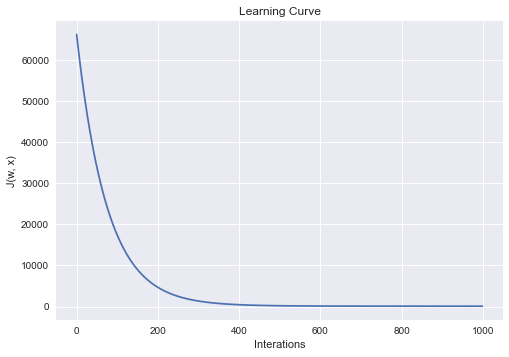

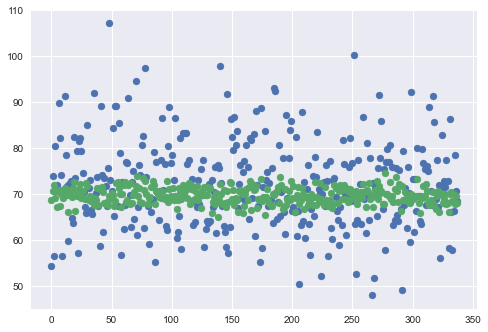

In [246]:
# assign some inital b and w values
# I will also need to divide the data set into a 80/20 training/testing in the future
train, test = train_test_split(cleanedData, test_size=0.2)

x_train = train.loc[:, train.columns != 'Score'].to_numpy()
y_train = train['Score'].to_numpy()

print(f'X: {x_train.shape}, Y: {y_train.shape}')

b_init = 0
w_init = np.random.randn(x_train.shape[1])

alpha = 1.0e-5

#best (MSE = 94.99) -> weight: [-0.00847274 -0.28399783  0.24662511  1.11587896  0.56957052 -0.189093530.37911873], b: -0.0023599778125182325

w_computed, b_computed, history = gradient_descent(x_train, y_train, w_init, b_init, alpha, 1000)

print(f"weight: {w_computed}, b: {b_computed}")
plot_learning_curve(history)
plot_predicted(x_train, y_train, w_computed, b_computed)

#### Improve Model Performance
Now I want to try to optimize the model with z-score normalization. The factors of driving distance and putts must be reduced to aligned with the rest of the percentage based features.

Changed the learning rate:
- too small, it will take too long and not reach a minimum
- too large, it will overshoot the minima (fail to converge/diverge)

In [186]:
#since driving distance, hole proximity and putts are not percentages, lets scale the date to increase gradient decent performance
def scaling_helper(df: pd.DataFrame):
    for i in df.columns:
        stdDev = df[i].std()
        mean = df[i].mean()
        
        df[i] = df[i].apply(lambda x: (x - mean)/stdDev)


C:\Users\kmong\AppData\Local\Temp\ipykernel_1664\4213354871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].apply(lambda x: (x - mean)/stdDev)


Iteration    0: Cost     4.09   
Iteration  100: Cost     3.79   
Iteration  200: Cost     3.69   
Iteration  300: Cost     3.65   
Iteration  400: Cost     3.64   
Iteration  500: Cost     3.63   
Iteration  600: Cost     3.63   
Iteration  700: Cost     3.62   
Iteration  800: Cost     3.62   
Iteration  900: Cost     3.62   
weight: [-0.07526007  0.18452831 -0.06226339  0.37749503  0.73809138 -0.56012325
 -0.04470201], b: 69.37981721489888
3.623691035422014


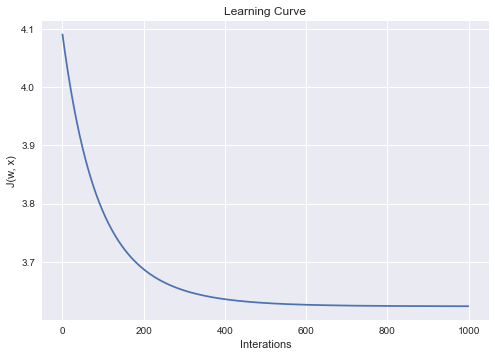

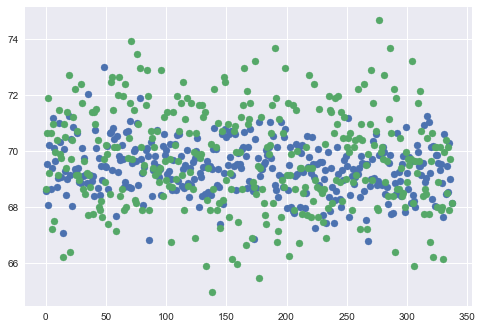

In [247]:
scaledDf = train.loc[:, train.columns != 'Score']
scaling_helper(scaledDf)

new_x_train = scaledDf.to_numpy()

alpha = 1.0e-1
b_init = np.average(y_train)

min_w = np.zeros((new_x_train.shape[1]))
min_b = 0
min_cost = 999

# best (MSE = 3.21) -> weight: [-0.37482006 -0.01586105 -0.08225523  0.58504955  0.5395469  -0.580925440 0.30640218], b: 70.22819209874864

# loop to generate different weights and test results
for i in range(20):
    w_init=np.random.randn(new_x_train.shape[1])
    w_computed, b_computed, scaled_history = gradient_descent(new_x_train, y_train, w_init, b_init, alpha, 1000)
    
    if(history[-1] < min_cost):
        min_w = w_computed
        min_b = b_computed
        min_cost = history[-1]

print(f"weight: {min_w}, b: {min_b}")
plot_learning_curve(scaled_history)
plot_predicted(new_x_train, y_train, min_w, min_b)

Let's compare the performance of my model to sklearn's linear regression model.

In [251]:
lowest_w = np.array([-0.37482006, -0.01586105, -0.08225523,  0.58504955,  0.5395469,  -0.580925440, 0.30640218])
lowest_b = 70.22819209874864

sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(new_x_train, y_train)

costSKL = compute_cost(new_x_train, y_train, sgdr.coef_, sgdr.intercept_[0])
costMine = compute_cost(new_x_train, y_train, lowest_w, lowest_b)

print(costSKL)
print(costMine)

print(f'My model has a cost function which is {round((1 - costSKL/costMine)*100, 2)} % higher than sklearns model')

2.460972263693333
3.3810906879442566
My model has a cost function which is 27.21 % higher than sklearns model


#### Testing

After determining the weights it will be important to run the model with new test data (seperated above).

C:\Users\kmong\AppData\Local\Temp\ipykernel_1664\4213354871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].apply(lambda x: (x - mean)/stdDev)


1.2704912420008552
2.4626562430894836


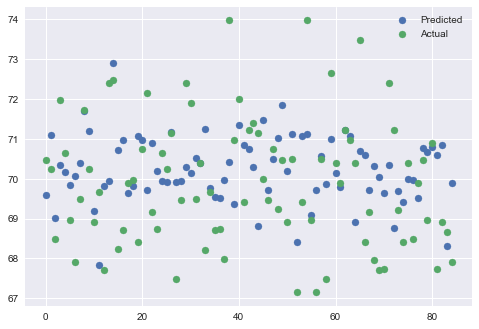

In [255]:
## TEST DATA
x_test = test.loc[:, test.columns != 'Score']
scaling_helper(x_test)

x_scaled = x_test.to_numpy()
y_test = test['Score'].to_numpy()

m, n = x_scaled.shape

predicted_y = np.zeros((m,))

mse = 0.0
for i in range(m):
    predicted_y[i] = np.dot(lowest_w, x_scaled[i]) + lowest_b
    mse += abs(predicted_y[i] - y_test[i]) 

print(mse/m)
plot_predicted(x_scaled, y_test, lowest_w, lowest_b)